In [1]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
# from torch.distributions import Normal, kl_divergence
from torchsummary import summary
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
image_dir = "C:/Users/Gert/repos/AML-exam-project/project/mvtec_anomaly_detection/carpet/train/"
transform_non_normal = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
dataset_non_normal = ImageFolder(root=image_dir, transform=transform_non_normal)
dataloader = DataLoader(dataset_non_normal, batch_size=32, shuffle=True)
print(len(dataloader)*32)

2912


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), 256, 8, 8)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Loss function

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [5]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
summary(model, (3,128,128), batch_size=32, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 64, 64]           1,568
              ReLU-2           [32, 32, 64, 64]               0
            Conv2d-3           [32, 64, 32, 32]          32,832
              ReLU-4           [32, 64, 32, 32]               0
            Conv2d-5          [32, 128, 16, 16]         131,200
              ReLU-6          [32, 128, 16, 16]               0
            Conv2d-7            [32, 256, 8, 8]         524,544
              ReLU-8            [32, 256, 8, 8]               0
            Linear-9                  [32, 128]       2,097,280
           Linear-10                  [32, 128]       2,097,280
           Linear-11                [32, 16384]       2,113,536
  ConvTranspose2d-12          [32, 128, 16, 16]         524,416
             ReLU-13          [32, 128, 16, 16]               0
  ConvTranspose2d-14           [32, 64,

In [7]:
def save_checkpoint(model, optimizer, epoch, file_path, losses):
    """
    Save the training state to a checkpoint file.

    Args:
        model: PyTorch model to save.
        optimizer: Optimizer used in training.
        epoch: Current epoch.
        file_path: Path to save the checkpoint.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'losses': losses
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved at {file_path}")

Epoch [31/100], Loss: 495.5009


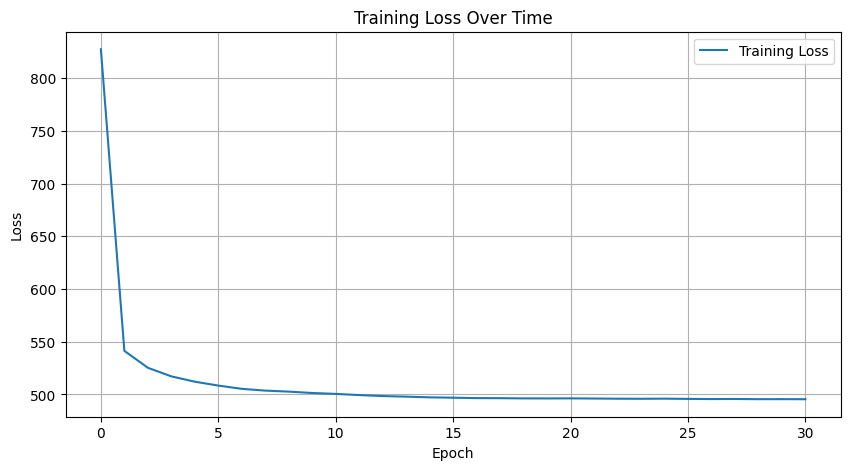

Batch Count: 1
Batch Count: 2
Batch Count: 3
Batch Count: 4
Batch Count: 5
Batch Count: 6
Batch Count: 7
Batch Count: 8
Batch Count: 9
Batch Count: 10
Batch Count: 11
Batch Count: 12
Batch Count: 13
Batch Count: 14
Batch Count: 15
Batch Count: 16
Batch Count: 17
Batch Count: 18
Batch Count: 19
Batch Count: 20
Batch Count: 21
Batch Count: 22
Batch Count: 23
Batch Count: 24
Batch Count: 25
Batch Count: 26
Batch Count: 27
Batch Count: 28
Batch Count: 29
Batch Count: 30
Batch Count: 31
Batch Count: 32
Batch Count: 33
Batch Count: 34
Batch Count: 35
Batch Count: 36
Batch Count: 37
Batch Count: 38
Batch Count: 39
Batch Count: 40
Batch Count: 41
Batch Count: 42


In [ ]:
# Training

losses = []
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    count = 0
    for images, _ in dataloader:
        images = images.to(device)
        
        # Forward pass
        reconstructed, mu, logvar = model(images)
        
        loss = vae_loss(reconstructed, images, mu, logvar)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        count += 1
        print(f"Batch Count: {count}")

    epoch_loss = round(train_loss / len(dataloader.dataset), 4)
    clear_output(wait=True)  # Clear the previous plot
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")
    losses.append(epoch_loss)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    if (epoch+1) % 10 == 0:
        save_checkpoint(model, optimizer, epoch, f"C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver12_{epoch+1}_epochs_checkpoint.pth", losses)


In [8]:
checkpoint_path = "C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver12_30_epochs_checkpoint.pth"

# Load checkpoint if resuming
if os.path.exists(checkpoint_path):  # Ensure file exists
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # Start from next epoch
    losses = checkpoint.get('losses', [])  # Load previous losses if available
    print(f"Resuming training from epoch {start_epoch+1}")
else:
    start_epoch = 0
    losses = []


Loading checkpoint...
Resuming training from epoch 30


C:\Users\Gert\AppData\Local\Temp\ipykernel_11044\4261615424.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


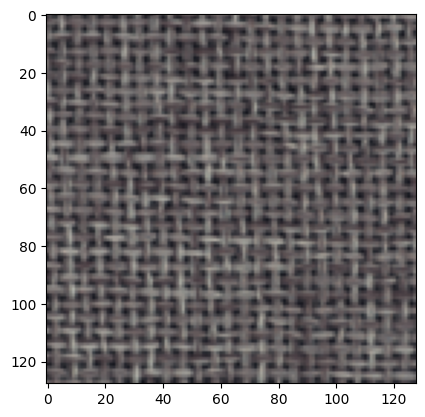

(32, 3, 128, 128)
torch.Size([128, 128, 3])


C:\Users\Gert\AppData\Local\Temp\ipykernel_11044\1491543505.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(output[0].cpu()).shape)


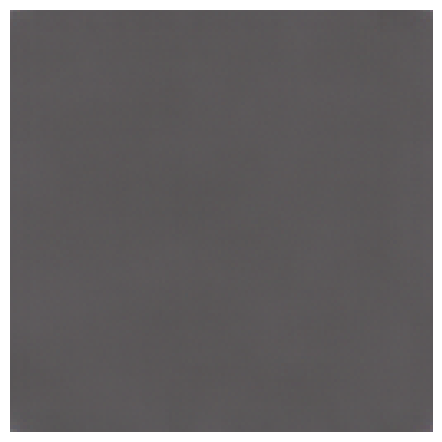

In [10]:
image = None
for i in dataloader:
    image = i
    break
# print(np.array(image[0][0]).shape)
image = image[0]
# print(image[0].reshape(512,512,-1).shape)
plt.imshow(image[0].permute(1, 2, 0))
plt.show()
# image_normalized = (image - mean[None, :, None, None]) / std[None, :, None, None]  # Normalize along the channel dimension

# Send the normalized image to the same device as the model (e.g., GPU or CPU)
image = image.to(device)
model = model.to(device)

# Run the image through the model
with torch.no_grad():  # Disable gradient calculations for inference
    output = model(image)
print(np.array(output[0].cpu()).shape)
reconstructed_image = output[0][0]

reconstructed_image = reconstructed_image.permute(1, 2, 0).cpu()  # Convert (C, H, W) -> (H, W, C)
print(reconstructed_image.shape)
# Display the reconstructed image
plt.imshow(reconstructed_image.cpu().numpy())
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()